# Example: Galveston Testbed

Reference paper: [Multi-hazard socio-physical resilience assessment of hurricane-induced hazards on coastal communities](https://www.sciencedirect.com/science/article/pii/S2772741623000388)

Reference notebook: [Latest Galveston Jupyter Notebook](https://github.com/npr99/IN-CORE_Galveston/blob/kooshan_main/jupyter_book/notebooks/complete_notebook.ipynb)


## 1. Prerequisites

### 1.1 Load packages

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx

from pyincore import IncoreClient, Dataset, DataService, HazardService, FragilityService, MappingSet, FragilityCurveSet
from pyincore import HHRSOutputProcess
from pyincore.utils.dataprocessutil import DataProcessUtil

# importing pyIncone analyses:
from pyincore.analyses.buildingdamage import BuildingDamage
from pyincore.analyses.buildingfunctionality import BuildingFunctionality
from pyincore.analyses.combinedwindwavesurgebuildingdamage import CombinedWindWaveSurgeBuildingDamage
from pyincore.analyses.epfdamage import EpfDamage
from pyincore.analyses.montecarlofailureprobability import MonteCarloFailureProbability
from pyincore.analyses.housingunitallocation import HousingUnitAllocation
from pyincore.analyses.populationdislocation import PopulationDislocation, PopulationDislocationUtil
from pyincore.analyses.housingrecoverysequential import HousingRecoverySequential
from pyincore.analyses.socialvulnerability import SocialVulnerability
from pyincore.analyses.capitalshocks import CapitalShocks

# Functions for visualizing the population data results as tables
from pyincore_viz.analysis.popresultstable import PopResultsTable as poptable
from pyincore_viz.geoutil import GeoUtil

In [2]:
client = IncoreClient()
# IN-CORE caches files on the local machine, it might be necessary to clear the memory
# client.clear_cache() 
data_service = DataService(client) # create data_service object for loading files
hazard_service = HazardService(client)
fragility_services = FragilityService(client)

Connection successful to IN-CORE services. pyIncore version detected: 1.13.0


In [3]:
client.clear_cache()

### 1.2 Define hazard

In [4]:
hazard_type = "hurricane"

# 100yr Hazard Event
hazard_id = "5fa5a9497e5cdf51ebf1add2"

# 500yr Hazard Event
#hazard_id = "5fa5aa19b6429615aeea4476"

# Galveston Hurricane Ike
# hazard_id = "5fa5a228b6429615aeea4410"



### 1.3 Define inventory

#### 1.3.1 Buildings

In [5]:
# Galveston inventory data
# bldg_dataset_id = "63053ddaf5438e1f8c517fed" # Full city
bldg_dataset_id = "63ff6b135c35c0353d5ed3ac" # Island Only
bldg_dataset_id

'63ff6b135c35c0353d5ed3ac'

#### 1.3.2 Power infrastructure

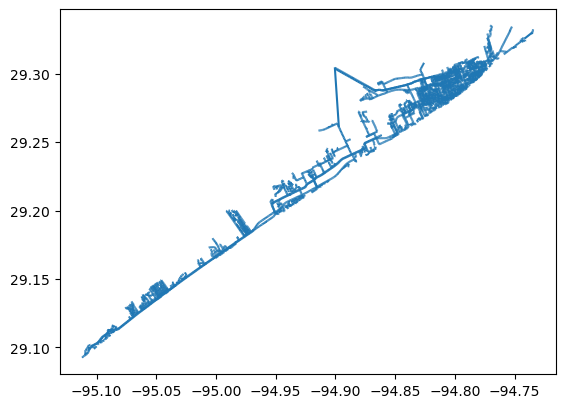

In [6]:
# Load shapefile
shp_power = './data/power_network/power_network.shp'
# Load the shapefile
gdf_power = gpd.read_file(shp_power)
# plot and show
gdf_power.plot()
plt.show()

#### 1.3.3 Transportation infrastructure

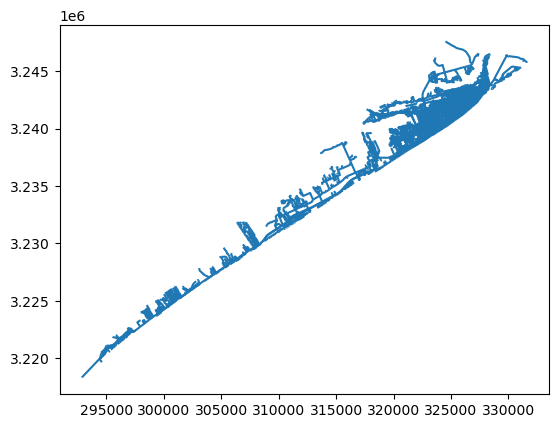

In [7]:
# Load shapefile
shp_transportation = './data/transportation_network/transportation_network.shp'
# Load the shapefile
gdf_transportation = gpd.read_file(shp_transportation)
# plot and show
gdf_transportation.plot()
plt.show()

#### 1.3.4 Paper figure

<img src="https://ars.els-cdn.com/content/image/1-s2.0-S2772741623000388-gr3_lrg.jpg" width="700"/>

## 2. Combined building damage

### 2.1 Wind building damage

In [8]:
# Building Wind Fragility mapping
mapping_id = "62fef3a6cef2881193f2261d"
fragility_service = FragilityService(client)
mapping_set = MappingSet(fragility_service.get_mapping(mapping_id))

In [9]:
# wind building damage
w_bldg_dmg = BuildingDamage(client)
w_bldg_dmg.load_remote_input_dataset("buildings", bldg_dataset_id)
w_bldg_dmg.set_input_dataset('dfr3_mapping_set', mapping_set)
w_bldg_dmg.set_parameter("result_name", "Galveston-wind-dmg")
w_bldg_dmg.set_parameter("hazard_type", hazard_type)
w_bldg_dmg.set_parameter("hazard_id", hazard_id)
w_bldg_dmg.set_parameter("num_cpu", 8)
w_bldg_dmg.run_analysis()

True

### 2.2 Surge-Wave building damage

In [10]:
# Surge-wave mapping
mapping_id = "6303e51bd76c6d0e1f6be080"
mapping_set = MappingSet(fragility_service.get_mapping(mapping_id))

In [11]:
# surge-wave building damage
sw_bldg_dmg = BuildingDamage(client)
sw_bldg_dmg.load_remote_input_dataset("buildings", bldg_dataset_id)
sw_bldg_dmg.set_input_dataset('dfr3_mapping_set', mapping_set)
sw_bldg_dmg.set_parameter("result_name", "Galveston-sw-dmg")
sw_bldg_dmg.set_parameter("hazard_type", hazard_type)
sw_bldg_dmg.set_parameter("hazard_id", hazard_id)
sw_bldg_dmg.set_parameter("num_cpu", 8)
sw_bldg_dmg.run_analysis()

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


True

### 2.3 Inundation (flood) building damage

In [12]:
# flood mapping
mapping_id = "62fefd688a30d30dac57bbd7"
mapping_set = MappingSet(fragility_service.get_mapping(mapping_id))

In [13]:
# flood building damage
f_bldg_dmg = BuildingDamage(client)
f_bldg_dmg.load_remote_input_dataset("buildings", bldg_dataset_id)
f_bldg_dmg.set_input_dataset('dfr3_mapping_set', mapping_set)
f_bldg_dmg.set_parameter("result_name", "Galveston-flood-dmg")
f_bldg_dmg.set_parameter("hazard_type", hazard_type)
f_bldg_dmg.set_parameter("hazard_id", hazard_id)
f_bldg_dmg.set_parameter("num_cpu", 8)
f_bldg_dmg.run_analysis()

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


True

### 2.4 Combine wind, surge-wave and flood building damage

#### 2.4.1 Hazard exposure example: surge-wave

In [14]:
surge_wave_damage = sw_bldg_dmg.get_output_dataset("ds_result")
wind_damage = w_bldg_dmg.get_output_dataset("ds_result")
flood_damage = f_bldg_dmg.get_output_dataset("ds_result")
#surge_wave_damage.get_dataframe_from_csv(low_memory=False)

data = surge_wave_damage.get_dataframe_from_csv(low_memory=False)
yes_count = len(data[data['haz_expose'] == 'yes'])
partial_count = len(data[data['haz_expose'] == 'partial'])
sum_count = yes_count + partial_count
total_rows = len(data)

print('Count of "yes":', yes_count)
print('Count of "partial":', partial_count)
print('Sum of "yes" and "partial":', sum_count)
print('Total number of rows:', total_rows)

Count of "yes": 26278
Count of "partial": 744
Sum of "yes" and "partial": 27022
Total number of rows: 29541


#### 2.4.2 Combined damage: setup

In [15]:
combined_bldg_dmg = CombinedWindWaveSurgeBuildingDamage(client)
result_name = "Galveston-combined-dmg"
combined_bldg_dmg.set_input_dataset("surge_wave_damage", surge_wave_damage)
combined_bldg_dmg.set_input_dataset("wind_damage", wind_damage)
combined_bldg_dmg.set_input_dataset("flood_damage", flood_damage)
combined_bldg_dmg.set_parameter("result_name", result_name)
combined_bldg_dmg.run_analysis()

True

#### 2.4.3 Hazard exposure example: combined

In [16]:
combined_dmg = combined_bldg_dmg.get_output_dataset("ds_result")
combined_dmg_df = combined_dmg.get_dataframe_from_csv(low_memory=False)

# Display top 5 rows of output data
combined_dmg_df.head()
combined_dmg_df.to_csv('combined_dmg_df.csv', index=False)

data = combined_dmg_df
yes_count = len(data[data['haz_expose'] == 'yes'])
partial_count = len(data[data['haz_expose'] == 'partial'])
sum_count = yes_count + partial_count
total_rows = len(data)

print('Count of "yes":', yes_count)
print('Count of "partial":', partial_count)
print('Sum of "yes" and "partial":', sum_count)
print('Total number of rows:', total_rows)

Count of "yes": 29526
Count of "partial": 11
Sum of "yes" and "partial": 29537
Total number of rows: 29541


### 2.5 Archetype mapping

In [17]:
buildings = Dataset.from_data_service(bldg_dataset_id, data_service)
bldg_gdf = buildings.get_dataframe_from_shapefile()
bldg_gdf.head()

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


,strctid,parid,struct_typ,year_built,no_stories,a_stories,b_stories,bsmt_type,sq_foot,gsq_foot,...,ffe_elev,g_elev,archetype,arch_wind,arch_flood,arch_sw,csv_guid,csv_sector,csv_val_st,geometry
0,STf3a21b5f-0334-4d77-911f-faa9a45c92d7,0,NaN,1980,2,0,0,0,47927,0,...,3.76991,3.46511,0,15,6,15,NaN,NaN,NaN,POINT (-94.81680 29.31409)
1,ST80ab0289-8c72-4699-b12b-08ef2f2a5c91,0,NaN,1954,1,0,0,0,100796,0,...,2.26048,1.95568,0,15,6,15,NaN,NaN,NaN,POINT (-94.82295 29.29635)
2,ST7916eaa8-0bfa-4b32-84ff-20f19a520f5c,0,NaN,1970,1,0,0,0,27121,0,...,2.68011,2.37531,0,15,6,15,7916eaa8-0bfa-4b32-84ff-20f19a520f5c,IRetail,2435054.5,POINT (-94.82423 29.29098)
3,ST79008971-a534-4e45-9e40-43a2a904e59b,0,NaN,2002,1,0,0,0,126333,0,...,2.91465,2.60985,0,15,6,15,79008971-a534-4e45-9e40-43a2a904e59b,IProfSer,4483599,POINT (-94.84045 29.29117)
4,ST2ad8ab6f-057f-468e-9911-6e92d9d4d01f,0,NaN,2002,1,0,0,0,114544,0,...,3.73770,3.43290,0,15,6,15,2ad8ab6f-057f-468e-9911-6e92d9d4d01f,IRealE,282702.06,POINT (-94.84242 29.29059)


In [18]:
arch_mapping = Dataset.from_data_service("63dc1f1362b9d001e6a1b485", data_service).get_dataframe_from_csv()
arch_mapping

,arch_wind,category,cluster
0,12.0,Critical Facilities,Critical Medical - Acute Care Hospitals
1,14.0,Critical Facilities,Emergency Operations Centers
2,11.0,Critical Facilities,Critical Government - First Responder Facilities
3,NaN,Critical Facilities,"Non-ambulatory Facilities - Prisons, nursing h..."
4,NaN,Emergency Housing,Emergency Shelters
5,NaN,Emergency Housing,Residential Housing
6,NaN,Emergency Housing,SFH and Multi-family
7,NaN,Housing / Neighborhood,Critical Retail
8,13.0,Housing / Neighborhood,Religious and Spiritual Centers
9,1.0,Housing / Neighborhood,Residential Housing


In [19]:
max_dmg_state_df = DataProcessUtil.get_max_damage_state(combined_dmg_df)
max_dmg_state_df

,guid,max_prob,max_state
0,f3a21b5f-0334-4d77-911f-faa9a45c92d7,0.656011,DS_0
1,80ab0289-8c72-4699-b12b-08ef2f2a5c91,0.711510,DS_2
2,7916eaa8-0bfa-4b32-84ff-20f19a520f5c,0.896200,DS_0
3,79008971-a534-4e45-9e40-43a2a904e59b,0.695918,DS_0
4,2ad8ab6f-057f-468e-9911-6e92d9d4d01f,0.575940,DS_0
...,...,...,...
29536,1ac5be10-582c-46b2-91ed-469f684bb886,0.999993,DS_3
29537,fbcfb6d6-de13-42fa-9839-d7c80afc651d,0.357067,DS_2
29538,2ee961c9-cd94-499e-b1fe-3e0220a440ea,0.545299,DS_2
29539,fa15cfbc-8a60-4a3f-b40f-7a6fada625b9,0.678298,DS_0


In [20]:
ret_json = DataProcessUtil.create_mapped_dmg_result(bldg_gdf, max_dmg_state_df, arch_mapping, "max_state", "arch_wind")
ret_json

{'by_cluster': [{'category': 'Critical Facilities',
   'cluster': 'Critical Medical - Acute Care Hospitals',
   'DS_0': 10,
   'DS_1': 5,
   'DS_2': 0,
   'DS_3': 0},
  {'category': 'Critical Facilities',
   'cluster': 'Emergency Operations Centers',
   'DS_0': -1,
   'DS_1': -1,
   'DS_2': -1,
   'DS_3': -1},
  {'category': 'Critical Facilities',
   'cluster': 'Critical Government - First Responder Facilities',
   'DS_0': -1,
   'DS_1': -1,
   'DS_2': -1,
   'DS_3': -1},
  {'category': 'Critical Facilities',
   'cluster': 'Non-ambulatory Facilities - Prisons, nursing homes, etc.',
   'DS_0': -1,
   'DS_1': -1,
   'DS_2': -1,
   'DS_3': -1},
  {'category': 'Emergency Housing ',
   'cluster': 'Emergency Shelters',
   'DS_0': -1,
   'DS_1': -1,
   'DS_2': -1,
   'DS_3': -1},
  {'category': 'Emergency Housing ',
   'cluster': 'Residential Housing',
   'DS_0': -1,
   'DS_1': -1,
   'DS_2': -1,
   'DS_3': -1},
  {'category': 'Emergency Housing ',
   'cluster': 'SFH and Multi-family',
   'DS

In [21]:
merged_gdf = bldg_gdf[['guid', 'geometry']].merge(max_dmg_state_df, left_on='guid', right_on='guid')
merged_gdf

,guid,geometry,max_prob,max_state
0,f3a21b5f-0334-4d77-911f-faa9a45c92d7,POINT (-94.81680 29.31409),0.656011,DS_0
1,80ab0289-8c72-4699-b12b-08ef2f2a5c91,POINT (-94.82295 29.29635),0.711510,DS_2
2,7916eaa8-0bfa-4b32-84ff-20f19a520f5c,POINT (-94.82423 29.29098),0.896200,DS_0
3,79008971-a534-4e45-9e40-43a2a904e59b,POINT (-94.84045 29.29117),0.695918,DS_0
4,2ad8ab6f-057f-468e-9911-6e92d9d4d01f,POINT (-94.84242 29.29059),0.575940,DS_0
...,...,...,...,...
29536,1ac5be10-582c-46b2-91ed-469f684bb886,POINT (-94.78968 29.28593),0.999993,DS_3
29537,fbcfb6d6-de13-42fa-9839-d7c80afc651d,POINT (-94.79154 29.28914),0.357067,DS_2
29538,2ee961c9-cd94-499e-b1fe-3e0220a440ea,POINT (-94.78782 29.29591),0.545299,DS_2
29539,fa15cfbc-8a60-4a3f-b40f-7a6fada625b9,POINT (-94.79564 29.29522),0.678298,DS_0


### 2.6 Plot results

#### 2.6.1 Combined building damage

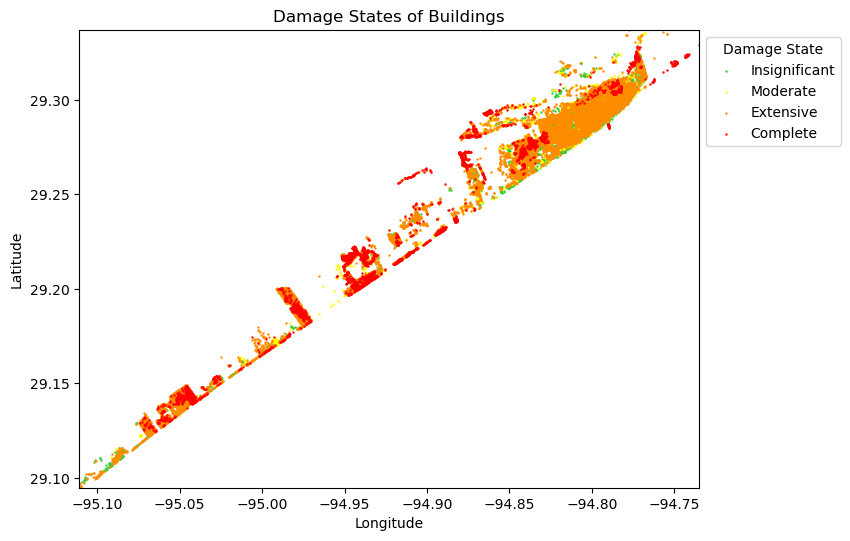

In [22]:
# Rename 'max_state' values for the legend
merged_gdf['max_state'] = merged_gdf['max_state'].replace({'DS_0': 'Insignificant',
                                                           'DS_1': 'Moderate',
                                                           'DS_2': 'Extensive',
                                                           'DS_3': 'Complete'})

# Define colors for each 'max_state'
colors = {'Insignificant': 'limegreen', 'Moderate': 'yellow', 'Extensive': 'darkorange', 'Complete': 'red'}

# Function to plot the data with different colors for each 'max_state'
def plot_data(point_size, use_basemap=True):
    # Plotting
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_facecolor('white')  # Set axes background to white

    # Determine bounds from the data
    bounds = merged_gdf.total_bounds
    ax.set_xlim([bounds[0], bounds[2]])
    ax.set_ylim([bounds[1], bounds[3]])

    # Plot each category with its color
    for state, color in colors.items():
        data_to_plot = merged_gdf[merged_gdf['max_state'] == state]
        data_to_plot.plot(ax=ax, markersize=point_size, color=color, label=state)

    # Add basemap if requested
    if use_basemap:
        try:
            ctx.add_basemap(ax, crs=merged_gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)
        except Exception as e:
            print(f"Failed to load basemap: {e}")

    # Add legend and labels
    plt.legend(title='Damage State', loc='upper left', bbox_to_anchor=(1, 1))
    plt.title('Damage States of Buildings')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    # Show plot
    plt.show()

# Example usage
plot_data(point_size=0.5, use_basemap=False)

#### 2.6.2 Paper figure

<img src="https://ars.els-cdn.com/content/image/1-s2.0-S2772741623000388-gr4_lrg.jpg" width="700"/>

## 3. Electric Power Pole Damage

In [23]:
# EPF fragility mapping
epf_mapping_id = "62fac92ecef2881193f22613"
epf_mapping_set = MappingSet(fragility_service.get_mapping(epf_mapping_id))

epf_dmg_hurricane_galveston = EpfDamage(client)
epf_dmg_hurricane_galveston.load_remote_input_dataset("epfs", "62fc000f88470b319561b58d")
epf_dmg_hurricane_galveston.set_input_dataset('dfr3_mapping_set', epf_mapping_set)
epf_dmg_hurricane_galveston.set_parameter("result_name", "Galveston-hurricane-epf-damage")
epf_dmg_hurricane_galveston.set_parameter("fragility_key", "Non-Retrofit Fragility ID Code")
epf_dmg_hurricane_galveston.set_parameter("hazard_type", hazard_type)
epf_dmg_hurricane_galveston.set_parameter("hazard_id", hazard_id)
epf_dmg_hurricane_galveston.set_parameter("num_cpu", 8)

# Run Analysis
epf_dmg_hurricane_galveston.run_analysis()
epf_dmg_result = epf_dmg_hurricane_galveston.get_output_dataset("result")

## 4. Monte Carlo sampling

### 4.1 Buildings

In [24]:
mc = MonteCarloFailureProbability(client)
mc.set_input_dataset("damage", combined_dmg)
mc.set_parameter("result_name", "combined_bldg_mc")
mc.set_parameter("num_cpu", 8)
mc.set_parameter("num_samples", 10)
mc.set_parameter("damage_interval_keys", ["DS_0", "DS_1", "DS_2", "DS_3"])
mc.set_parameter("failure_state_keys", ["DS_1", "DS_2", "DS_3"])
mc.run_analysis()

gal_bldg_damage_mcs_samples = mc.get_output_dataset('sample_failure_state')
gal_bldg_damage_mcs_samples_df = gal_bldg_damage_mcs_samples.get_dataframe_from_csv()
gal_bldg_damage_mcs_samples_df.head()

,guid,failure
0,f3a21b5f-0334-4d77-911f-faa9a45c92d7,"1,0,1,0,0,0,1,0,1,0"
1,80ab0289-8c72-4699-b12b-08ef2f2a5c91,"0,0,0,0,0,0,0,0,0,0"
2,7916eaa8-0bfa-4b32-84ff-20f19a520f5c,"1,1,1,1,1,1,1,1,0,1"
3,79008971-a534-4e45-9e40-43a2a904e59b,"1,1,1,1,1,1,0,0,0,0"
4,2ad8ab6f-057f-468e-9911-6e92d9d4d01f,"1,1,0,1,1,0,1,1,0,0"


### 4.2 Electric power poles

In [25]:
gal_bldg_failure_probability = mc.get_output_dataset('failure_probability')  # get buildings failure probabilities

In [26]:
mc = MonteCarloFailureProbability(client)
mc.set_input_dataset("damage", epf_dmg_result)
mc.set_parameter("result_name", "epf_mc")
mc.set_parameter("num_cpu", 8)
mc.set_parameter("num_samples", 10)
mc.set_parameter("damage_interval_keys", ["DS_0", "DS_1", "DS_2", "DS_3"])
mc.set_parameter("failure_state_keys", ["DS_1", "DS_2", "DS_3"])
mc.run_analysis()

gal_pole_damage_mcs_samples = mc.get_output_dataset('sample_failure_state')
gal_pole_damage_mcs_samples_df = gal_pole_damage_mcs_samples.get_dataframe_from_csv()
gal_pole_damage_mcs_samples_df.head()

,guid,failure
0,2525e200-cdc6-4fb8-9952-f17579176fd8,"1,1,1,1,1,1,1,1,1,1"
1,9180f947-26ae-40bd-85f5-83a80525f6c8,"1,1,1,1,1,1,1,1,1,1"
2,11ddc2dc-cc92-4c90-b4cc-a99b92a26f4b,"1,1,1,1,1,1,1,1,1,1"
3,9e58f196-9a2c-40b1-b722-69fa9c53c9d4,"1,1,1,1,1,1,1,1,1,1"
4,a4de2d54-b251-4a02-af0c-d12e0dc3670c,"1,1,1,1,1,1,1,1,1,1"


## 5. Building functionality

In [27]:
gal_bldg_func = BuildingFunctionality(client)
    
gal_bldg_func.set_input_dataset("building_damage_mcs_samples", gal_bldg_damage_mcs_samples)
gal_bldg_func.set_input_dataset("poles_damage_mcs_samples", gal_pole_damage_mcs_samples)
gal_bldg_func.load_remote_input_dataset("interdependency_dictionary", "63e5af0262d82d2f5a1058ea")

gal_bldg_func.set_parameter("result_name", "gal_mcs_functionality_probability")
gal_bldg_func.run_analysis()

gal_bldg_func_samples_df = gal_bldg_func.get_output_dataset('functionality_samples').get_dataframe_from_csv()
gal_bldg_func_samples_df.head()

,building_guid,samples
0,f3a21b5f-0334-4d77-911f-faa9a45c92d7,"1,0,1,0,0,0,1,0,1,0"
1,80ab0289-8c72-4699-b12b-08ef2f2a5c91,"0,0,0,0,0,0,0,0,0,0"
2,7916eaa8-0bfa-4b32-84ff-20f19a520f5c,"1,1,1,1,1,1,1,1,0,1"
3,79008971-a534-4e45-9e40-43a2a904e59b,"1,0,1,1,0,0,0,0,0,0"
4,2ad8ab6f-057f-468e-9911-6e92d9d4d01f,"1,1,0,1,1,0,1,1,0,0"


In [28]:
df_gal_bldg_func_probability = gal_bldg_func.get_output_dataset('functionality_probability').get_dataframe_from_csv()
df_gal_bldg_func_probability = df_gal_bldg_func_probability.rename(columns={"building_guid": "guid"})
func_prob_target = 0.50
df_gal_bldg_func_probability.loc[df_gal_bldg_func_probability['probability'].isna(), 'functionality'] = 1 # Assumed to be connected to an undamaged/unanalyzed power network for now.
df_gal_bldg_func_probability.loc[df_gal_bldg_func_probability['probability'] <= func_prob_target, 'functionality'] = 0 # Non-Functional
df_gal_bldg_func_probability.loc[df_gal_bldg_func_probability['probability'] > func_prob_target, 'functionality'] = 1 # Functional
df_gal_bldg_func_probability.loc[df_gal_bldg_func_probability['probability'].isna(), 'functionality_state'] = 'Functional' # Assumed to be connected to an undamaged/unanalyzed power network for now.
df_gal_bldg_func_probability.loc[df_gal_bldg_func_probability['probability'] <= func_prob_target, 'functionality_state'] = 'Non-Functional' # Non-Functional
df_gal_bldg_func_probability.loc[df_gal_bldg_func_probability['probability'] > func_prob_target, 'functionality_state'] = 'Functional' # Functional
df_gal_bldg_func_probability.head()


,guid,probability,functionality,functionality_state
0,f3a21b5f-0334-4d77-911f-faa9a45c92d7,0.4,0.0,Non-Functional
1,80ab0289-8c72-4699-b12b-08ef2f2a5c91,0.0,0.0,Non-Functional
2,7916eaa8-0bfa-4b32-84ff-20f19a520f5c,0.9,1.0,Functional
3,79008971-a534-4e45-9e40-43a2a904e59b,0.3,0.0,Non-Functional
4,2ad8ab6f-057f-468e-9911-6e92d9d4d01f,0.6,1.0,Functional


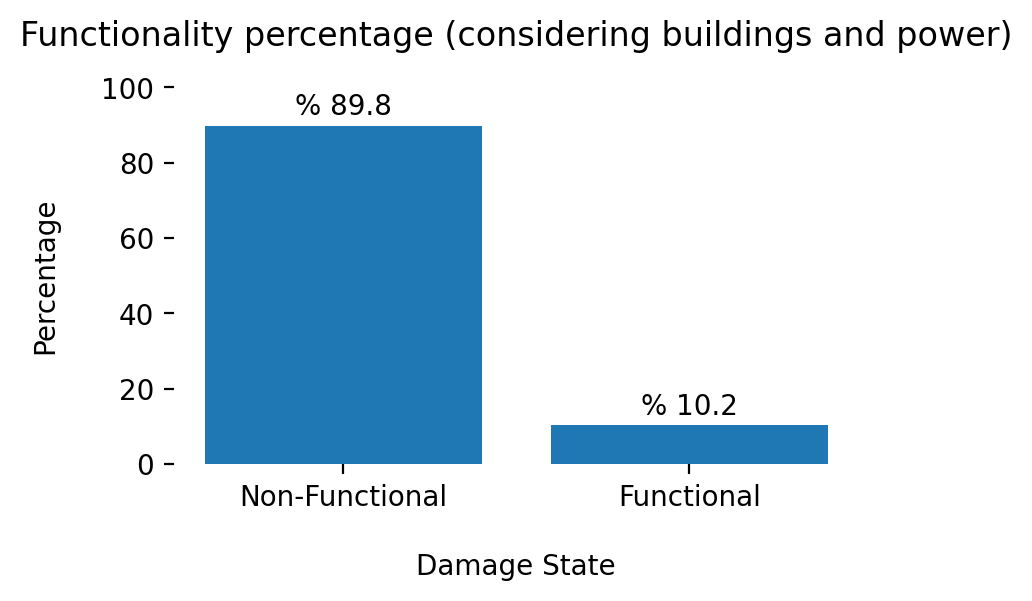

In [29]:
### Plot of the distribution of functionality state for buildings
indexes = df_gal_bldg_func_probability['functionality_state'].value_counts(normalize=True).mul(100).index.tolist()
values = df_gal_bldg_func_probability['functionality_state'].value_counts(normalize=True).mul(100).tolist()

fig, ax = plt.subplots(figsize=(4, 2.5), dpi=200)

bars = ax.bar(x=indexes, height=values,)

for bar in bars:
    ax.text(bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 3,f'% {bar.get_height() :.1f}',
            horizontalalignment='center')

fig.tight_layout()
ax.set_ylim([0,100])
ax.set_xlabel('Damage State', labelpad=15)
ax.set_ylabel('Percentage', labelpad=15)
ax.set_title('Functionality percentage (considering buildings and power)', pad=15)
ax.set(frame_on=False);

## 6. Capital Shocks

In [30]:
# Create Capital shocks analysis
capital_shocks = CapitalShocks(client)
building_to_sectors_id = "640200da475d895dfc2de1bd"
# Load remote datasets
capital_shocks.load_remote_input_dataset("buildings_to_sectors", building_to_sectors_id)
capital_shocks.load_remote_input_dataset("buildings", bldg_dataset_id)
capital_shocks.set_input_dataset("failure_probability", gal_bldg_failure_probability)

capital_shocks.set_parameter("result_name", "sector_shocks") # name of csv file with results

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


True

In [31]:
# Run capital shocks analysis
capital_shocks.run_analysis()

sector_shocks_result = capital_shocks.get_output_dataset("sector_shocks")
sector_shocks_result.get_dataframe_from_csv()

,sector,shock
0,HS3I,0.231995
1,HS2I,0.170012
2,HS1I,0.256569
3,IPROFSER,0.336513
4,IRETAIL,0.312660
5,IART,0.335676
6,ICONS,0.215296
7,IHEALTH,0.332826
8,ITRANS,0.189783
9,IREALE,0.373701


## 7. Population dislocation - Multihazard Comparison

### 7.1 Setup general population data

In [32]:
pop_dis = PopulationDislocation(client)
value_loss = "60354810e379f22e16560dbd"
bg_data = "603545f2dcda03378087e708"
# hua_result_id = "63ee615d62b9d001e6a2b660" # city
hua_result_id = "63ff8e895367c2261b4cb2ef" # island

pop_dis.load_remote_input_dataset("block_group_data", bg_data)
pop_dis.load_remote_input_dataset("value_loss_param", value_loss)
pop_dis.load_remote_input_dataset("housing_unit_allocation", hua_result_id)

### 7.2 Initial loop for dislocation
The following code is used to create a set of dateframes for each hazard type and the combined damage. Each data frame has details on the population dislocation for the hazard.

In [33]:
# Create an empty dictionary to store the results
popdis_results_df = {}
popdis_results_df_mincols = {}
damage_types = {"flood_damage" : flood_damage,
                "wind_damage" : wind_damage,
                "surge_wave_damage" : surge_wave_damage,
                "combined_dmg" : combined_dmg}

# loop through the damage types
for damage, damage_result in damage_types.items():
    pop_dis.set_input_dataset("building_dmg", damage_result)

    result_name = f"galveston-pop-disl-results_{damage}"
    seed = 1111

    pop_dis.set_parameter("result_name", result_name)
    pop_dis.set_parameter("seed", seed)
    pop_dis.run_analysis()

    population_dislocation_result = pop_dis.get_output_dataset("result")
    popdis_results_df[damage] = population_dislocation_result.get_dataframe_from_csv(low_memory=False)

    # Keep HUID, prdis and dislocated columns
    popdis_results_df_mincols[damage] = popdis_results_df[damage][['guid','huid', 'prdis', 'dislocated']]

    # Print the number of dislocated housholds by HUID
    print(f"For {damage} ",popdis_results_df_mincols[damage]['dislocated'].sum(), " households are dislocated")

For flood_damage  10067  households are dislocated
For wind_damage  14292  households are dislocated
For surge_wave_damage  10007  households are dislocated
For combined_dmg  14896  households are dislocated


### 7.3 Clean and merge dislocation data
The following code loops through the damage type dataframes, cleans up the columns and prepares the data for a merge.

In [34]:
popdis_merge_df = {}
# loop through the damage types
for damage, damage_result in damage_types.items():
    # Read in CSV and convert to dataframe
    damage_df = damage_result.get_dataframe_from_csv(low_memory=False)
    # For each damage type merge damage states and hazard exposure
    popdis_merge_df[damage] = pd.merge(
                                right = popdis_results_df_mincols[damage], 
                                left = damage_df[['guid','DS_0','DS_1','DS_2','DS_3','haz_expose']], 
                                left_on='guid', 
                                right_on='guid', 
                                how='right')

    # flag observations with damage exposure
    condition1 = (popdis_merge_df[damage]['haz_expose'] == 'yes')
    popdis_merge_df[damage][f'{damage}_exp'] = np.where((condition1), 1, 0)

    # flag observations that are not dislocated and DS_3 > .5
    # households that do not dislocate but have a high probability of damage
    condition1 = (popdis_merge_df[damage]['dislocated'] == 0)
    condition2 = (popdis_merge_df[damage]['DS_3'] > .5)
    popdis_merge_df[damage]['dsds3flag'] = np.where((condition1) & (condition2), 1, 0)

    # flag observations that are dislocated and DS_0 > .5
    # households that dislocate but have a low probability of damage
    condition1 = (popdis_merge_df[damage]['dislocated'] == 1)
    condition2 = (popdis_merge_df[damage]['DS_0'] > .5)
    popdis_merge_df[damage]['dsds0flag'] = np.where((condition1) & (condition2), 1, 0)

    # rename popdis_merge_df with damage type
    popdis_merge_df[damage] = popdis_merge_df[damage].rename(columns={"dsds3flag" : f"dsds3flag_{damage}",
                                                                     "dsds0flag" : f"dsds0flag_{damage}",
                                                                     "guid" : f"guid_{damage}",
                                                                     "prdis" : f"prdis_{damage}",
                                                                     "dislocated" : f"dislocated_{damage}",
                                                                     "DS_0": f"DS_0_{damage}",
                                                                     "DS_1": f"DS_1_{damage}",  
                                                                     "DS_2": f"DS_2_{damage}",
                                                                     "DS_3": f"DS_3_{damage}",
                                                                     "haz_expose": f"haz_expose_{damage}"})

   

# merge all the damage types
popdis_multihazard_df = pd.merge(right = popdis_merge_df['flood_damage'],
                                    left = popdis_merge_df['wind_damage'],
                                    left_on='huid',
                                    right_on='huid',
                                    how='outer')
popdis_multihazard_df = pd.merge(right = popdis_multihazard_df,
                                    left = popdis_merge_df['surge_wave_damage'],
                                    left_on='huid',
                                    right_on='huid',
                                    how='outer')                              
popdis_multihazard_df = pd.merge(right = popdis_multihazard_df,
                                    left = popdis_merge_df['combined_dmg'],
                                    left_on='huid',
                                    right_on='huid',
                                    how='outer')
# drop all the guid columns and rename guid_x to guid
popdis_multihazard_df = popdis_multihazard_df.drop(columns=['guid_flood_damage','guid_wind_damage','guid_surge_wave_damage'])
popdis_multihazard_df = popdis_multihazard_df.rename(columns={"guid_combined_dmg" : "guid"})   

In [35]:
popdis_multihazard_df.columns
#popdis_multihazard_df.to_csv('./output/building/dislocation_results/dislocation_building.csv', index=False)

Index(['guid', 'DS_0_combined_dmg', 'DS_1_combined_dmg', 'DS_2_combined_dmg',
       'DS_3_combined_dmg', 'haz_expose_combined_dmg', 'huid',
       'prdis_combined_dmg', 'dislocated_combined_dmg', 'combined_dmg_exp',
       'dsds3flag_combined_dmg', 'dsds0flag_combined_dmg',
       'DS_0_surge_wave_damage', 'DS_1_surge_wave_damage',
       'DS_2_surge_wave_damage', 'DS_3_surge_wave_damage',
       'haz_expose_surge_wave_damage', 'prdis_surge_wave_damage',
       'dislocated_surge_wave_damage', 'surge_wave_damage_exp',
       'dsds3flag_surge_wave_damage', 'dsds0flag_surge_wave_damage',
       'DS_0_wind_damage', 'DS_1_wind_damage', 'DS_2_wind_damage',
       'DS_3_wind_damage', 'haz_expose_wind_damage', 'prdis_wind_damage',
       'dislocated_wind_damage', 'wind_damage_exp', 'dsds3flag_wind_damage',
       'dsds0flag_wind_damage', 'DS_0_flood_damage', 'DS_1_flood_damage',
       'DS_2_flood_damage', 'DS_3_flood_damage', 'haz_expose_flood_damage',
       'prdis_flood_damage', 'dislocate

### 7.4 Merge in infrastructure analyses on transportation and power

In [36]:
# read in insfrastructure result from a CSV file
networkdamage_df = pd.read_csv("./data/infrastructures_recovery_result/final_df_with_building.csv")

# for network df keep only the first unique guid - todo: This probably needs to be changed
networkdamage_df = networkdamage_df.drop_duplicates(subset=['guid'], keep='first')
networkdamage_df['guid'].describe()

# keep guid, power_back_time, transpo_back_time
networkdamage_df = networkdamage_df[['guid','average_power_back_time','average_transpo_back_time']]

# Considering with and without power/transpo in the next analyses
#networkdamage_df['average_transpo_back_time'] = 0.0   # Uncomment to exclude the impact of transportation on population displacement.
#networkdamage_df['average_power_back_time'] = 0.0   # Uncomment to exclude the impact of power on population displacement.
networkdamage_df

,guid,average_power_back_time,average_transpo_back_time
0,7916eaa8-0bfa-4b32-84ff-20f19a520f5c,0.000,0.0
1,42167885-ea18-41b4-be8c-5c09c330d312,5.836,0.0
2,3dab0b4b-42eb-4df6-a5e1-c1882df41704,0.000,0.0
3,e474c4ef-a091-47ab-85b4-ef0459e37834,0.000,0.0
73,335d18da-7a60-4f4d-8c97-d35e0f3a1360,0.000,0.0
...,...,...,...
33297,7a415cb6-d212-450b-b139-f005c89b9656,0.000,0.0
33298,74e5fedf-9e22-4434-9128-65ca793df7d2,0.000,0.0
33299,1ac5be10-582c-46b2-91ed-469f684bb886,0.000,0.0
33300,fbcfb6d6-de13-42fa-9839-d7c80afc651d,0.000,0.0


<img src="https://ars.els-cdn.com/content/image/1-s2.0-S2772741623000388-gr7_lrg.jpg" width="700"/>


In [37]:
networkdamage_df['guid'].describe()

count                                    22015
unique                                   22015
top       7916eaa8-0bfa-4b32-84ff-20f19a520f5c
freq                                         1
Name: guid, dtype: object

In [38]:
popdis_multihazard_df['guid'].describe()

count                                    33302
unique                                   22015
top       2669f722-ae95-4181-90a8-9c4755b7b29c
freq                                       191
Name: guid, dtype: object

In [39]:
# merge network damage with popdis_multihazard_df by guid
popdis_multihazard_network_df = pd.merge(right = popdis_multihazard_df,
                                    left = networkdamage_df,
                                    left_on='guid',
                                    right_on='guid',
                                    how='inner')
popdis_multihazard_network_df['guid'].describe()

count                                    33302
unique                                   22015
top       2669f722-ae95-4181-90a8-9c4755b7b29c
freq                                       191
Name: guid, dtype: object

### 7.5 Add Flag for Power Outage and Road Closure
- Choosing cutoffs for 3 days without power and 7 days without road access.
- These cutoffs are expert judgments and could be changed.

In [40]:
# If the power_back_time greater than 7 days then dislocated_power = 1
condition1 = (popdis_multihazard_network_df['average_power_back_time'] > 3)
popdis_multihazard_network_df['powerflag'] = np.where((condition1), 1, 0)

# if transpo_back_time greater than 14 days then dislocated_transpo = 1
condition1 = (popdis_multihazard_network_df['average_transpo_back_time'] > 7)
popdis_multihazard_network_df['transpoflag'] = np.where((condition1), 1, 0)

In [41]:
# loop through the damage types
for damage, damage_result in damage_types.items():
    # add case where dislocated = 0 but dislocated_power == 1
    condition1 = (popdis_multihazard_network_df[f'dislocated_{damage}'] == 0)
    condition2 = (popdis_multihazard_network_df['powerflag'] == 1)
    popdis_multihazard_network_df[f'powerflag_{damage}'] = \
        np.where((condition1) & (condition2), 1, 0)
    
    # add case where dislocated = 0 but dislocated_transpo == 1
    condition1 = (popdis_multihazard_network_df[f'dislocated_{damage}'] == 0)
    condition2 = (popdis_multihazard_network_df['transpoflag'] == 1)
    popdis_multihazard_network_df[f'transpoflag_{damage}'] = \
        np.where((condition1) & (condition2), 1, 0)
    
    # identify safe occupany housholds no flags 
    condition1 = (popdis_multihazard_network_df[f'dsds3flag_{damage}'] == 0)
    condition2 = (popdis_multihazard_network_df[f'dsds0flag_{damage}'] == 0)
    condition3 = (popdis_multihazard_network_df[f'powerflag_{damage}'] == 0)
    condition4 = (popdis_multihazard_network_df[f'transpoflag_{damage}'] == 0)
    popdis_multihazard_network_df[f'safeflag_{damage}'] = \
        np.where((condition1) & (condition2) & (condition3) & (condition4), 1, 0)

    # how many households have hazard exposure = yes
    hazexpose = popdis_multihazard_network_df[f'{damage}_exp'].sum()
    # how many households have dsds0flag or dsds3flag true
    totaldislocation = popdis_multihazard_network_df[f'dislocated_{damage}'].sum()
    choicedislocation = popdis_multihazard_network_df[f'dsds0flag_{damage}'].sum()
    hazardnondislocation = popdis_multihazard_network_df[f'dsds3flag_{damage}'].sum()
    nopower_nodislocation = popdis_multihazard_network_df[f'powerflag_{damage}'].sum()
    notranspo_nodislocation = popdis_multihazard_network_df[f'transpoflag_{damage}'].sum()
    safe_occupancy = popdis_multihazard_network_df[f'safeflag_{damage}'].sum()
    print(f"{damage} Number of households with hazard exposure: {hazexpose}")
    print(f"{damage} Total number of dislocated households: {totaldislocation}")
    print(f"{damage} Number of households that dislocate but have a low probability of damage: {choicedislocation}")
    print(f"{damage} Number of households that do not dislocate and have no power: {nopower_nodislocation}")
    print(f"{damage} Number of households that do not dislocate and have no connectivity to mainland: {notranspo_nodislocation}")
    print(f"{damage} Number of households with safe occupancy: {safe_occupancy}")

flood_damage Number of households with hazard exposure: 32964
flood_damage Total number of dislocated households: 10067
flood_damage Number of households that dislocate but have a low probability of damage: 1190
flood_damage Number of households that do not dislocate and have no power: 4821
flood_damage Number of households that do not dislocate and have no connectivity to mainland: 5581
flood_damage Number of households with safe occupancy: 25638
wind_damage Number of households with hazard exposure: 33295
wind_damage Total number of dislocated households: 14292
wind_damage Number of households that dislocate but have a low probability of damage: 1989
wind_damage Number of households that do not dislocate and have no power: 3307
wind_damage Number of households that do not dislocate and have no connectivity to mainland: 3802
wind_damage Number of households with safe occupancy: 26749
surge_wave_damage Number of households with hazard exposure: 30463
surge_wave_damage Total number of d

### 7.6 Modify dislocation for HHSR
The HHSR model assumes that if a household dislocates then the structure is not safe to occupy and will take time to recover. However, the dislocation model has households that dislocate but the structure has a high probability of being safe to occupy. Vice versa, the model also has households that do not dislcate but the structure has a high probability of being unsafe to occupy.

If a household has choice dislocation (dsds0flag_) then dislocation should be set to 0. 

If a household has unsafe occupancy (dsds3flag_) then dislocation should be set to 1.

In [42]:
popdis_hhrs_df = popdis_multihazard_network_df.copy()

In [43]:
# loop through the damage types
for damage, damage_result in damage_types.items():
    # update dislocation if dsds0flag_ = 1
    totaldislocation1 = popdis_hhrs_df[f'dislocated_{damage}'].sum()
    condition1 = (popdis_hhrs_df[f'dsds0flag_{damage}'] == 1)
    popdis_hhrs_df[f'dislocated_{damage}'] = \
        np.where((condition1), 0, popdis_hhrs_df[f'dislocated_{damage}'])
    totaldislocation2 = popdis_hhrs_df[f'dislocated_{damage}'].sum()
    print(f"{damage} Swith Choice Dislocation Total number of dislocated households: {totaldislocation1} {totaldislocation2}")

    # update dislocation if dsds3flag_ = 1
    totaldislocation1 = popdis_hhrs_df[f'dislocated_{damage}'].sum()
    condition1 = (popdis_hhrs_df[f'dsds3flag_{damage}'] == 1)
    popdis_hhrs_df[f'dislocated_{damage}'] = \
        np.where((condition1), 1, popdis_hhrs_df[f'dislocated_{damage}'])
    totaldislocation2 = popdis_hhrs_df[f'dislocated_{damage}'].sum()
    print(f"{damage} Switch unsafe occupancy Total number of dislocated households: {totaldislocation1} {totaldislocation2}")


flood_damage Swith Choice Dislocation Total number of dislocated households: 10067 8877
flood_damage Switch unsafe occupancy Total number of dislocated households: 8877 8971
wind_damage Swith Choice Dislocation Total number of dislocated households: 14292 12303
wind_damage Switch unsafe occupancy Total number of dislocated households: 12303 12715
surge_wave_damage Swith Choice Dislocation Total number of dislocated households: 10007 8616
surge_wave_damage Switch unsafe occupancy Total number of dislocated households: 8616 8909
combined_dmg Swith Choice Dislocation Total number of dislocated households: 14896 13563
combined_dmg Switch unsafe occupancy Total number of dislocated households: 13563 14288


In [44]:
popdis_hhrs_df.columns

Index(['guid', 'average_power_back_time', 'average_transpo_back_time',
       'DS_0_combined_dmg', 'DS_1_combined_dmg', 'DS_2_combined_dmg',
       'DS_3_combined_dmg', 'haz_expose_combined_dmg', 'huid',
       'prdis_combined_dmg', 'dislocated_combined_dmg', 'combined_dmg_exp',
       'dsds3flag_combined_dmg', 'dsds0flag_combined_dmg',
       'DS_0_surge_wave_damage', 'DS_1_surge_wave_damage',
       'DS_2_surge_wave_damage', 'DS_3_surge_wave_damage',
       'haz_expose_surge_wave_damage', 'prdis_surge_wave_damage',
       'dislocated_surge_wave_damage', 'surge_wave_damage_exp',
       'dsds3flag_surge_wave_damage', 'dsds0flag_surge_wave_damage',
       'DS_0_wind_damage', 'DS_1_wind_damage', 'DS_2_wind_damage',
       'DS_3_wind_damage', 'haz_expose_wind_damage', 'prdis_wind_damage',
       'dislocated_wind_damage', 'wind_damage_exp', 'dsds3flag_wind_damage',
       'dsds0flag_wind_damage', 'DS_0_flood_damage', 'DS_1_flood_damage',
       'DS_2_flood_damage', 'DS_3_flood_damage', 'ha

In [45]:
# loop through the damage types to consider dislocation due to power outage and road closure
for damage, damage_result in damage_types.items():
    # update dislocation if powerflag & transpoflag = 1
    totaldislocation1 = popdis_hhrs_df[f'dislocated_{damage}'].sum()
    condition1 = (popdis_hhrs_df[f'powerflag_{damage}'] == 1)
    condition2 = (popdis_hhrs_df[f'transpoflag_{damage}'] == 1)
    popdis_hhrs_df[f'dislocated_{damage}'] = \
        np.where(((condition1) | (condition2)), 1, popdis_hhrs_df[f'dislocated_{damage}'])
    totaldislocation2 = popdis_hhrs_df[f'dislocated_{damage}'].sum()
    print(f"{damage} Total number of dislocated households without and with power and tranportation effects: {totaldislocation1} {totaldislocation2}")

flood_damage Total number of dislocated households without and with power and tranportation effects: 8971 15351
wind_damage Total number of dislocated households without and with power and tranportation effects: 12715 16867
surge_wave_damage Total number of dislocated households without and with power and tranportation effects: 8909 14771
combined_dmg Total number of dislocated households without and with power and tranportation effects: 14288 18026


In [46]:
# Keep only columns needed for HHSR
# drop all columns with flag
popdis_hhrs_df = popdis_hhrs_df[popdis_hhrs_df.columns.drop(list(popdis_hhrs_df.filter(regex='flag')))]
# drop all columns with DS
popdis_hhrs_df = popdis_hhrs_df[popdis_hhrs_df.columns.drop(list(popdis_hhrs_df.filter(regex='DS')))]
# drop all columns with prdis
popdis_hhrs_df = popdis_hhrs_df[popdis_hhrs_df.columns.drop(list(popdis_hhrs_df.filter(regex='prdis')))]
# drop all columns with haz_expose
popdis_hhrs_df = popdis_hhrs_df[popdis_hhrs_df.columns.drop(list(popdis_hhrs_df.filter(regex='haz_expose')))]
# drop all columns with exp
popdis_hhrs_df = popdis_hhrs_df[popdis_hhrs_df.columns.drop(list(popdis_hhrs_df.filter(regex='exp')))]
# Drop column named dislocated 
# popdis_hhrs_df = popdis_hhrs_df.drop(columns=['dislocated'])
popdis_hhrs_df.columns

Index(['guid', 'average_power_back_time', 'average_transpo_back_time', 'huid',
       'dislocated_combined_dmg', 'dislocated_surge_wave_damage',
       'dislocated_wind_damage', 'dislocated_flood_damage'],
      dtype='object')

In [47]:
# Adding required columns for running the HHRS model from IN-CORE 
# HHRS code in IN-CORE needs to be edited; race, hispan, ownershp data is no more required
popdis_hhrs_df = pd.merge(right = popdis_results_df[damage][['huid','blockid', 'race', 'hispan', 'ownershp']],
                          left = popdis_hhrs_df,
                          left_on='huid',
                          right_on='huid',
                          how='inner')

In [48]:
popdis_hhrs_df['guid'].describe()

count                                    33302
unique                                   22015
top       2669f722-ae95-4181-90a8-9c4755b7b29c
freq                                       191
Name: guid, dtype: object

In [49]:
dislocated_types = ['dislocated_flood_damage', 'dislocated_wind_damage', 'dislocated_surge_wave_damage', 'dislocated_combined_dmg']
hhrs_dislocation_dataset_names = {}
for dislocation in dislocated_types:
    popdis_hhrs_df_temp = pd.DataFrame()
    popdis_hhrs_df_temp = popdis_hhrs_df[['guid', 'huid', 'blockid', 'race', 'hispan', 'ownershp', dislocation]]
    popdis_hhrs_df_temp = popdis_hhrs_df_temp.rename(columns={dislocation: 'dislocated'})
    popdis_hhrs_df_temp['dislocated'] = popdis_hhrs_df_temp['dislocated'].astype(bool)
    popdis_hhrs_dataset = Dataset.from_dataframe(popdis_hhrs_df_temp,
                                             name=f"popdis_hhrs_dataset_{dislocation}",
                                             data_type="incore:popDislocation")
    hhrs_dislocation_dataset_names[f"popdis_hhrs_dataset_{dislocation}"] = popdis_hhrs_dataset

<img src="https://ars.els-cdn.com/content/image/1-s2.0-S2772741623000388-gr6_lrg.jpg" width="700"/>

## 8. Housing Household Recovery Sequentials

### 8.1 Social vulnerabilities

In [50]:
# importing censusutils
from pyincore_data.censusutil import CensusUtil

In [51]:
# Parameters
state = "texas"
county = "galveston"
year = 2019

In [52]:
# get fips code to use fetch census data
fips = CensusUtil.get_fips_by_state_county(state=state, county=county)
state_code = fips[:2]
county_code = fips[2:]

In [53]:
navs = CensusUtil.national_ave_values(year=year)
national_vulnerability_feature_averages = Dataset.from_csv_data(navs, name="national_vulnerability_feature_averages.csv",
                                                                 data_type="incore:socialVulnerabilityFeatureAverages")

geo_type = "block%20group:*"
# geo_type = "tract:*"
social_vulnerability_dem_factors_df = CensusUtil.demographic_factors(state_code, county_code, year=year,
                                                                      geo_type=geo_type)

# Temp fix: remove bad data point
social_vulnerability_dem_factors_df = social_vulnerability_dem_factors_df.dropna()

social_vulnerability_dem_factors = Dataset.from_dataframe(social_vulnerability_dem_factors_df,
                                                           name="social_vunlnerability_dem_factors",
                                                           data_type="incore:socialVulnerabilityDemFactors")

csv saved as api_20231215-014448.csv
csv saved as api_20231215-014449.csv
csv saved as api_20231215-014450.csv
csv saved as api_20231215-014451.csv
csv saved as api_20231215-014452.csv
csv saved as api_20231215-014453.csv
csv saved as api_20231215-014454.csv
csv saved as api_20231215-014455.csv
csv saved as api_20231215-014456.csv
csv saved as api_20231215-014457.csv


In [54]:
social_vulnerability = SocialVulnerability(client)

social_vulnerability.set_parameter("result_name", "gal_social_vulnerabilty")
social_vulnerability.set_input_dataset("national_vulnerability_feature_averages", national_vulnerability_feature_averages)
social_vulnerability.set_input_dataset("social_vulnerability_demographic_factors", social_vulnerability_dem_factors)

social_vulnerability.run_analysis()
sv_result = social_vulnerability.get_output_dataset("sv_result")

In [55]:
df = sv_result.get_dataframe_from_csv()

### 8.2 Run simulation

In [56]:
# Population dislocation result aggregated to the block group level.
# Transition probability matrix per social vulnerability level.
transition_probability_matrix = "60f5e2ae544e944c3cec0794"
# Initial mass probability function for stage 0.
initial_probability_vector = "60f5e918544e944c3cec668b"

# Create housing recovery instance
housing_recovery = HousingRecoverySequential(client)

# Load input datasets
for keys, values in hhrs_dislocation_dataset_names.items():
    housing_recovery.set_input_dataset("population_dislocation_block", values)
    housing_recovery.load_remote_input_dataset("tpm", transition_probability_matrix)
    housing_recovery.load_remote_input_dataset("initial_stage_probabilities", initial_probability_vector) 
    
    # Chain with SV output
    housing_recovery.set_input_dataset('sv_result', sv_result)

    # Initial value to seed the random number generator to ensure replication
    seed = 1111
    # A size of the analysis time step.
    t_delta = 1.0
    # Total duration.
    t_final = 90.0    
    


    # Specify the result name
    result_name = f"housing_recovery_result_{keys}"

    # Set analysis parameters
    housing_recovery.set_parameter("result_name", result_name)
    housing_recovery.set_parameter("seed", seed)
    housing_recovery.set_parameter("t_delta", t_delta)
    housing_recovery.set_parameter("t_final", t_final)
    housing_recovery.set_parameter("num_cpu", 8)

    housing_recovery.run()
    
    result = housing_recovery.get_output_dataset("ds_result")
    hh_stagehistory_df = result.get_dataframe_from_csv()
    #timesteps = ["1", "7", "13", "25", "85"] # t0, t6, t12, t24, t84
    timesteps = ["1", "2", "3", "4", "5", "6", "7", "13", "25", "37", "49", "61", "73", "85"]
    HHRSOutputProcess.get_hhrs_stage_count(timesteps, hh_stagehistory_df,
                                           filename_json=f"hhrs_stage_count_{keys}.json")


Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


In [57]:
hh_stagehistory_df['guid'].describe()

count                                    33302
unique                                   22015
top       2669f722-ae95-4181-90a8-9c4755b7b29c
freq                                       191
Name: guid, dtype: object

### 8.3 Results: multi-hazard

<img src="https://ars.els-cdn.com/content/image/1-s2.0-S2772741623000388-gr9_lrg.jpg" width="700"/>


### 8.3 Results: infrastructure

<img src="https://ars.els-cdn.com/content/image/1-s2.0-S2772741623000388-gr10_lrg.jpg" width="700"/>